# Explore Topic Models
Explores the topic models of forum posts with LDA (Latent Dirichlet Allocation)

## TODO
- Tutorial
 - https://towardsdatascience.com/topic-modelling-in-python-with-nltk-and-gensim-4ef03213cd21
 - https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python


## Imports

In [1]:
from gensim import corpora, models
import pickle
from pathlib import Path
from io import FileIO
import pyLDAvis.gensim
from gensim.models import LdaModel, LdaMulticore
from lemmatize import *
from scraping import create_connection

In [2]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

/home/mwh/miniconda3/envs/forum/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## Functions

In [3]:
def load_data(forum="all", group="all", id_type="family_id"):
    lemmatized_text = pickle.load(open(path_lemma_pkl.format(forum, group, id_type), 'rb'))
    corpus = pickle.load(open(path_corpus_pkl.format(forum, group, id_type), 'rb'))
    dictionary = corpora.Dictionary.load(path_dictionary_gensim.format(forum, group, id_type))
    return lemmatized_text, corpus, dictionary

In [4]:
def gen_cols(n):
    return ["topic_{}".format(str(i).zfill(2)) for i in range(n)]

## File Locations

In [5]:
p = Path.cwd()
path_parent = p.parents[0]

In [6]:
# database
path_db = str(path_parent / "database" / "youbemom-merged.db")
# data to load
path_lemma_pkl = str(path_parent / "clean_data" / "lemmatized_text_{0}_{1}_{2}.pkl")
path_corpus_pkl = str(path_parent / "clean_data" / "corpus_{0}_{1}_{2}.pkl")
path_dictionary_gensim = str(path_parent / "clean_data" / "dictionary_{0}_{1}_{2}.gensim")
# model saving
path_tune_models = str(path_parent / "clean_data" / "lda_tune_{0}_{1}_{2}_{3}_{4}.gensim")
path_ntopic_models = str(path_parent / "clean_data" / "lda_ntopics_{0}_{1}_{2}_{3}.gensim")
# path_coherence = str(path_parent / "clean_data" / "coherence_{}.csv")
path_log = str(path_parent / "clean_data" / "logging_{0}_{1}_{2}_{3}.log")
path_log_iterations = str(path_parent / "clean_data" / "logging_{0}_{1}_{2}_{3}.log")
# dominant topic
path_dom_topic = str(path_parent / "clean_data" / "dominant_topic_{0}_{1}_{2}_{3}.csv")
# clean text
path_clean_text = str(path_parent / "clean_data" / "clean_text_{0}_{1}.csv")
# topics
path_topic_percents = str(path_parent / "clean_data" / "topics_{0}_{1}_{2}.csv")

## Load Data

In [7]:
args = {
    'special-needs':{'n_passes':100, 'n_iterations':200, 'n_topics':[5, 10, 15, 20, 25, 30, 40, 50]},
    'tween-teen':   {'n_passes':120, 'n_iterations':400, 'n_topics':[2, 3, 4, 5, 7, 10, 15, 20, 25, 30, 40, 50]},
    'preschool':    {'n_passes':100, 'n_iterations':400, 'n_topics':[2, 3, 4, 5, 7, 10, 15, 20, 25, 30]},
    'elementary':   {'n_passes':130, 'n_iterations':400, 'n_topics':[2, 3, 4, 5, 7, 10, 15, 20, 25, 30]},
    'new-york-city':{'n_passes':150, 'n_iterations':400, 'n_topics':[2, 3, 4, 5, 7, 10, 15, 20, 25, 30, 40, 50]},
    'school':       {'n_passes':200, 'n_iterations':400, 'n_topics':[2, 3, 4, 5, 7, 10, 15, 20, 25, 30, 40, 50]},
    'toddler':      {'n_passes':35,  'n_iterations':200, 'n_topics':[5, 10, 15, 20, 25, 30, 40, 50]}
}

In [9]:
sf = "special-needs"
n = 20

In [11]:
group = 'all'
id_type = 'family_id'

In [24]:
mod_dict = {}
for i in args[sf]["n_topics"]:
    mod_dict[str(i)] = LdaModel.load(path_ntopic_models.format(sf, group, id_type, str(i)))

In [12]:
lemmatized_text, corpus, dictionary = load_data(sf, group, id_type)

In [13]:
date_sql = '''
    SELECT family_id, date_created
    FROM posts
    WHERE subforum=?
    AND parent_id=""
'''

In [14]:
sen_sql = '''
    SELECT s.family_id, s.com_sen_clean
    FROM sentiment_family AS s
    INNER JOIN (SELECT DISTINCT family_id FROM posts WHERE subforum=?) AS p
    ON s.family_id = p.family_id
'''

In [15]:
conn = create_connection(path_db)
dates = pd.read_sql(date_sql, conn, params=(sf,))
sen = pd.read_sql(sen_sql, conn, params=(sf,))

In [16]:
clean_text = pd.read_csv(path_clean_text.format(sf, group))

In [17]:
text = clean_text[['family_id','text_clean']].groupby(['family_id'])['text_clean'].apply(' '.join)
text = text.to_frame()
text.reset_index(inplace=True)

In [18]:
text_merged = text.merge(dates, how="left", on="family_id")
text_merged = text_merged.merge(sen, how="left", on="family_id")

In [19]:
text_merged['date_created'] = pd.to_datetime(text_merged['date_created'])

In [20]:
positive = (text_merged['com_sen_clean'] >= 0.05)
negative = (text_merged['com_sen_clean'] <= 0.05)
neutral = ~positive & ~negative
text_merged['positive'] = 0
text_merged['negative'] = 0
text_merged['neutral'] = 0
text_merged.loc[positive, 'positive'] = 1
text_merged.loc[negative, 'negative'] = 1
text_merged.loc[neutral, 'neutral'] = 1
text_merged = text_merged.set_index(['date_created'])

In [38]:
days = text_merged.groupby(pd.Grouper(freq='D')).agg(
    {
        'positive': 'sum',
        'negative': 'sum',
        'neutral': 'sum'
    }
)
weeks = text_merged.groupby(pd.Grouper(freq='W')).agg(
    {
        'positive': 'sum',
        'negative': 'sum',
        'neutral': 'sum'
    }
)
months = text_merged.groupby(pd.Grouper(freq='M')).agg(
    {
        'positive': 'sum',
        'negative': 'sum',
        'neutral': 'sum'
    }
)

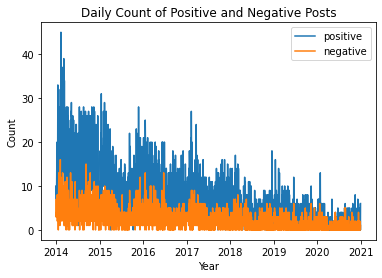

In [33]:
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots()
ax.plot(days.index, days['positive'], label='positive')
ax.set_xlabel("Year")
ax.set_ylabel("Count")
ax.plot(days.index, days['negative'], label='negative')
plt.title("Daily Count of Positive and Negative Posts")
plt.legend(loc="upper right")
plt.savefig(path_parent / "plots" / "sentiment_daily_count_family.png")

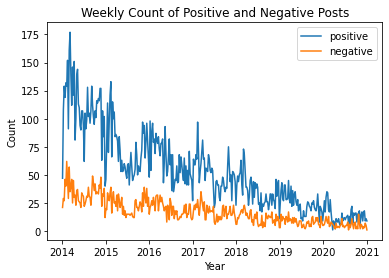

In [66]:
%matplotlib inline

fig, ax = plt.subplots()
ax.plot(weeks.index, weeks['positive'], label='positive')
ax.set_xlabel("Year")
ax.set_ylabel("Count")
ax.plot(weeks.index, weeks['negative'], label='negative')
plt.title("Weekly Count of Positive and Negative Posts")
plt.legend(loc="upper right")
plt.savefig(path_parent / "plots" / "sentiment_weekly_count_family.png")

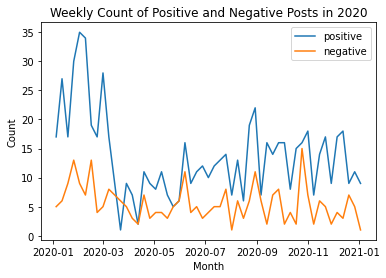

In [85]:
%matplotlib inline

weeks_2020 = weeks[(weeks.index >= pd.to_datetime('2020-01-01'))].copy()
fig, ax = plt.subplots()
ax.plot(weeks_2020.index, weeks_2020['positive'], label='positive')
ax.set_xlabel("Month")
ax.set_ylabel("Count")
ax.plot(weeks_2020.index, weeks_2020['negative'], label='negative')
plt.title("Weekly Count of Positive and Negative Posts in 2020")
plt.legend(loc="upper right")
plt.savefig(path_parent / "plots" / "sentiment_weekly_count_family_2020.png")

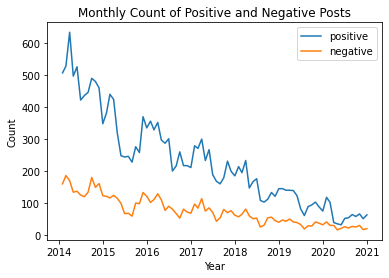

In [39]:
%matplotlib inline

fig, ax = plt.subplots()
ax.plot(months.index, months['positive'], label='positive')
ax.set_xlabel("Year")
ax.set_ylabel("Count")
ax.plot(months.index, months['negative'], label='negative')
plt.title("Monthly Count of Positive and Negative Posts")
plt.legend(loc="upper right")
plt.savefig(path_parent / "plots" / "sentiment_monthly_count_family.png")

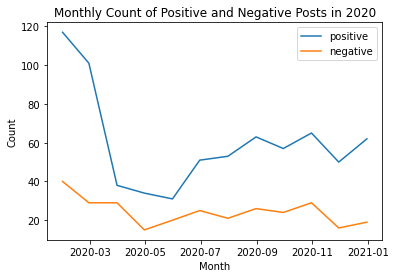

In [40]:
%matplotlib inline

months_2020 = months[(months.index >= pd.to_datetime('2020-01-01'))].copy()
fig, ax = plt.subplots()
ax.plot(months_2020.index, months_2020['positive'], label='positive')
ax.set_xlabel("Month")
ax.set_ylabel("Count")
ax.plot(months_2020.index, months_2020['negative'], label='negative')
plt.title("Monthly Count of Positive and Negative Posts in 2020")
plt.legend(loc="upper right")
plt.savefig(path_parent / "plots" / "sentiment_monthly_count_family_2020.png")

Assign topic distribution to text

In [25]:
out = np.zeros((len(corpus), n), dtype=float, order='C')
for i, doc in enumerate(corpus):
    topics = mod_dict[str(n)].get_document_topics(doc)
    for j, score in topics:
        out[i,j] = score

In [26]:
cols = gen_cols(n)
df = pd.concat([text_merged.reset_index(), pd.DataFrame(out, columns=cols)], axis=1)

Text(0, 0.5, 'Count')

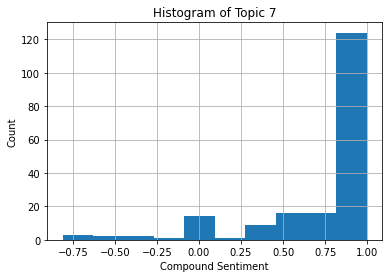

In [86]:
import pylab as pl
df.loc[df['dom_topic']=='topic_07'].hist(column='com_sen_clean')
pl.title("Histogram of Topic 7")
pl.xlabel("Compound Sentiment")
pl.ylabel("Count")

Text(0, 0.5, 'Count')

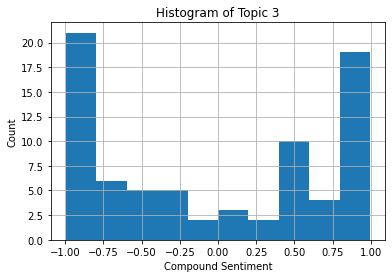

In [87]:
df.loc[df['dom_topic']=='topic_03'].hist(column='com_sen_clean')
pl.title("Histogram of Topic 3")
pl.xlabel("Compound Sentiment")
pl.ylabel("Count")

Topic distribution and sentiment

In [27]:
df['dom_topic'] = df[cols].idxmax(axis=1, skipna=True)

In [62]:
df['dom_topic'].value_counts()

topic_09    12504
topic_18     6184
topic_10     2789
topic_02     2440
topic_15      540
topic_06      291
topic_16      201
topic_07      188
topic_03       77
topic_11       72
topic_19       51
topic_05       50
topic_14       35
topic_17       26
topic_04       10
topic_13        1
topic_00        1
topic_08        1
Name: dom_topic, dtype: int64

In [61]:
df.groupby(['dom_topic']).agg({'com_sen_clean':'mean'})

,com_sen_clean
dom_topic,
topic_00,0.897900
topic_02,0.552390
topic_03,-0.014643
topic_04,0.291830
topic_05,0.261944
topic_06,0.505615
topic_07,0.736456
topic_08,0.859100
topic_09,0.450772


Topic distribution over time

In [30]:
df = df[(df['date_created'] < pd.to_datetime('2021-01-01'))]

In [ ]:
# create csv of topic percents and text
# df.drop('date_created', axis=1).to_csv(path_topic_percents.format(sf, group, n), index=False)

In [31]:
df = df.set_index(['date_created'])

In [32]:
weeks = df[cols].groupby(pd.Grouper(freq='W')).sum()
weeks['total'] = weeks[cols].sum(axis=1)
weeks[cols] = weeks[cols].div(weeks["total"], axis=0)

In [ ]:
months = df[cols].groupby(pd.Grouper(freq='M')).sum()
months['total'] = months[cols].sum(axis=1)
months[cols] = months[cols].div(months["total"], axis=0)
cummonth = months[cols].cumsum(axis=1)

In [ ]:
path_data = str(path_parent / "clean_data" / "clean_data_{}_{}_{}_{}_{}.csv")
months.to_csv(path_data.format(sf, group, id_type, str(n), "month"), index=True)

In [ ]:
weeks.to_csv(path_data.format(sf, group, id_type, str(n), "week"), index=True)

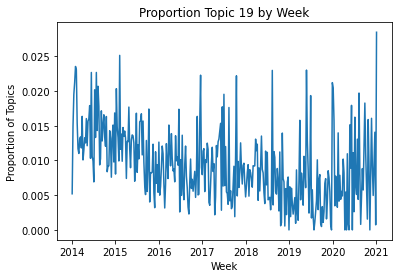

In [37]:
import matplotlib.pyplot as plt
t = 19
plt.plot(weeks.index, weeks['topic_{}'.format(str(t).zfill(2))])
plt.xlabel("Week")
plt.ylabel("Proportion of Topics")
plt.title("Proportion Topic {} by Week".format(t))
plt.savefig(path_parent / "plots" / "topic_distribution_{}_weekly_topic_{}_of_{}.png".format(sf, str(t), str(n)))

In [ ]:
clean_text.to_csv(path_data.format(sf, group, id_type, str(n), "sen"), index=False)

In [ ]:
def hex(h):
    return "#" + h

In [ ]:
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
fig, ax = plt.subplots()
width = 0.35
colors = ["95F9C3","8EEFBE","86E5B9","7FDBB4","78D0AF","71C6AB","69BCA6","62B2A1","5BA89C","549E97","4C9392","45898D","3E7F88","377583","2F6B7E","28617A","215675","1A4C70","12426B","0B3866"]
ax.bar(months.index, months[cols[0]], width=100, label='Topic {}'.format(0), color=hex(colors[0]))
for i in range(1, n):
    ax.bar(months.index, months[cols[i]], bottom=cummonth[cols[i-1]], width=100, label='Topic {}'.format(i), color=hex(colors[i]))
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
fig.set_size_inches(12, 10)
fig.savefig(path_parent / "plots" / "topic_distribution_{}_{}.png".format(sf, str(n)))

In [ ]:
c = df[cols].corr()

In [ ]:
c

In [ ]:
# ones = df[cols].apply(np.ceil)
# c = ones[cols].corr()

In [ ]:
import seaborn as sns
# mask = np.triu(np.ones_like(c, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(c, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.savefig(path_parent / "plots" / "topic_corr_{}_{}.png".format(sf, str(n)))

In [ ]:
df_sen = df.merge(clean_text[['message_id','com_sen_clean']], on="message_id", how="left")

In [ ]:
df_sen['topic'] = df_sen[cols].idxmax(axis=1)

In [ ]:
g = sns.boxplot(x="topic", y="com_sen_clean", data=df_sen, width=0.5)
g.set_xticklabels(g.get_xticklabels(), rotation=30)

In [ ]:
df_sen.groupby('topic')['com_sen_clean'].mean()

## Toddler

In [ ]:
sf = "toddler"
n = 15

In [ ]:
lemmatized_text, corpus, dictionary = load_data(sf, group, id_type)

In [ ]:
mod_dict = {}
for i in args[sf]["n_topics"]:
    mod_dict[str(i)] = LdaModel.load(path_ntopic_models.format(sf, group, id_type, str(i)))

In [ ]:
clean_text = pd.read_csv(path_clean_text.format(sf, group))
temp = clean_text[['family_id']]
temp.to_sql("temp", conn, if_exists='replace')

In [ ]:
date_sql = '''
    SELECT family_id, message_id, date_created
    FROM posts
    WHERE subforum=?
        AND parent_id=""
        AND family_id IN (SELECT family_id FROM temp)
'''

In [ ]:
dates = pd.read_sql(date_sql, conn, params=(sf,))
dates = dates.drop('message_id', axis=1)

In [ ]:
text = clean_text[['family_id','text_clean']].groupby(['family_id'])['text_clean'].apply(' '.join)
text = text.to_frame()
text.reset_index(inplace=True)
df = text.merge(dates, how="left", on="family_id")
df.reset_index(drop=True, inplace=True)
df['date_created'] = pd.to_datetime(df['date_created'])
out = np.zeros((len(corpus), n), dtype=float, order='C')
for i, doc in enumerate(corpus):
    topics = mod_dict[str(n)].get_document_topics(doc)
    for j, score in topics:
        out[i,j] = score
cols = gen_cols(n)
df = pd.concat([df, pd.DataFrame(out, columns=cols)], axis=1)
df = df[(df['date_created'] < pd.to_datetime('2021-01-01'))]
df.reset_index(drop=True, inplace=True)
df.drop('date_created', axis=1).to_csv(path_topic_percents.format(sf, group, n), index=False)

In [ ]:
df = df.set_index(['date_created'])
weeks = df[cols].groupby(pd.Grouper(freq='W')).sum()
weeks['total'] = weeks[cols].sum(axis=1)
weeks[cols] = weeks[cols].div(weeks["total"], axis=0)
months = df[cols].groupby(pd.Grouper(freq='M')).sum()
months['total'] = months[cols].sum(axis=1)
months[cols] = months[cols].div(months["total"], axis=0)
cummonth = months[cols].cumsum(axis=1)
months.to_csv(path_data.format(sf, group, id_type, str(n), "month"), index=True)
weeks.to_csv(path_data.format(sf, group, id_type, str(n), "week"), index=True)

In [ ]:
import matplotlib.pyplot as plt
t = 14
plt.plot(weeks.index, weeks['topic_{}'.format(str(t).zfill(2))])
plt.xlabel("Week")
plt.ylabel("Proportion of Topics")
plt.title("Proportion Topic {} by Week".format(t))
# plt.savefig(path_parent / "plots" / "topic_distribution_{}_weekly_topic_{}_of_{}.png".format(sf, str(t), str(n)))

In [ ]:
colsums = pd.DataFrame(out).sum()
totalsum = colsums.sum()
100 * colsums / totalsum

In [ ]:
df.to_csv(path_data.format(sf, group, id_type, str(n), "df"), index=False)

In [ ]:
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
fig, ax = plt.subplots()
width = 0.35
colors = ["95F9C3","8EEFBE","86E5B9","7FDBB4","78D0AF","71C6AB","69BCA6","62B2A1","5BA89C","549E97","4C9392","45898D","3E7F88","377583","2F6B7E","28617A","215675","1A4C70","12426B","0B3866"]
ax.bar(months.index, months[cols[0]], width=100, label='Topic {}'.format(0), color=hex(colors[0]))
for i in range(1, n):
    ax.bar(months.index, months[cols[i]], bottom=cummonth[cols[i-1]], width=100, label='Topic {}'.format(i), color=hex(colors[i]))
# ax.bar(months.index, women_means, width, yerr=women_std, bottom=men_means,
#        label='Women')
# ax.set_ylabel('Scores')
# ax.set_title('Scores by group and gender')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
fig.set_size_inches(12, 10)
fig.savefig(path_parent / "plots" / "topic_distribution_{}_{}.png".format(sf, str(n)))

## Visualize Topics

In [ ]:
pyLDAvis.display(pyLDAvis.gensim.prepare(ldamodel, corpus, dictionary, sort_topics=False))

## Most Representative Post for Each Topic

In [ ]:
topic_sentences = format_topics_sentences(ldamodel, corpus)

In [ ]:
topic_sentences.info()

In [ ]:
df_joined = pd.concat([df.reset_index(drop=True), topic_sentences.reset_index(drop=True)], axis=1)

In [ ]:
df_joined.to_csv(path_topic.format('special-needs', 'all'), sep='\t', index=False)

In [ ]:
topic_dominant = pd.DataFrame()
topic_grouped = df_joined.groupby('Dominant_Topic')
for i, grp in topic_grouped:
    topic_dominant = pd.concat([topic_dominant,
                                grp.sort_values(['Perc_Contribution'],
                                                ascending=[0]).head(3)],
                               axis=0)
topic_dominant.reset_index(drop=True, inplace=True)
topic_dominant.info()

In [ ]:
for t in topic_dominant['text_clean']:
    print(t)